# 🍷 Youth Alcohol Use Prediction Using Tree-Based Models
This notebook explores social, behavioral, and demographic factors contributing to alcohol consumption among youth using decision tree-based methods.

We use machine learning problem types:
- **Binary Classification** (Alcohol Use: Yes/No)
We evaluate Decision Tree, Bagging, Random Forest, and Gradient Boosting models using accuracy, F1-score, confusion matrices. 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve, roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight


df = pd.read_csv("youth_data.csv")

common_missing_codes = [ 94, 97, 98, 99, 991]
df = df.replace(common_missing_codes, np.nan)


target = 'ALCFLAG'

selected_predictors = [
    'IRMJAGE', 'EDUSCHGRD2', 'TOBFLAG', 'NEWRACE2',
    'EDUSKPCOM', 'HEALTH2', 'INCOME', 'POVERTY3', 'DRPRVME3',
    'FRDADLY2', 'PRVDRGO2', 'PRPROUD2',
    'PRTALK3', 'TALKPROB', 'PREVIOL2', 'FRDMJMON', 'SCHFELT'
]

df = df.dropna(subset=[target] + selected_predictors)


X = df[selected_predictors]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 37  48]
 [ 50 179]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.44      0.43        85
           1       0.79      0.78      0.79       229

    accuracy                           0.69       314
   macro avg       0.61      0.61      0.61       314
weighted avg       0.69      0.69      0.69       314



In [2]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

tree_summary = export_text(model, feature_names=X.columns.tolist())
print(tree_summary)

|--- TOBFLAG <= 0.50
|   |--- EDUSCHGRD2 <= 5.50
|   |   |--- NEWRACE2 <= 6.50
|   |   |   |--- EDUSCHGRD2 <= 3.50
|   |   |   |   |--- class: 0
|   |   |   |--- EDUSCHGRD2 >  3.50
|   |   |   |   |--- PRPROUD2 <= 1.50
|   |   |   |   |   |--- NEWRACE2 <= 1.50
|   |   |   |   |   |   |--- EDUSKPCOM <= 0.50
|   |   |   |   |   |   |   |--- HEALTH2 <= 1.50
|   |   |   |   |   |   |   |   |--- PRVDRGO2 <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- PRVDRGO2 >  1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- HEALTH2 >  1.50
|   |   |   |   |   |   |   |   |--- HEALTH2 <= 3.50
|   |   |   |   |   |   |   |   |   |--- IRMJAGE <= 13.50
|   |   |   |   |   |   |   |   |   |   |--- PRTALK3 <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- PRTALK3 >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   | 

In [3]:
importances = pd.DataFrame({'feature_name': X.columns, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

   feature_name  importance
0    EDUSCHGRD2    0.160538
1     EDUSKPCOM    0.123175
2      NEWRACE2    0.105930
3       IRMJAGE    0.094738
4       HEALTH2    0.067556
5      PRPROUD2    0.059614
6       TOBFLAG    0.058587
7      FRDMJMON    0.057495
8       PRTALK3    0.055307
9       SCHFELT    0.048165
10     DRPRVME3    0.037802
11       INCOME    0.033277
12     POVERTY3    0.027380
13     FRDADLY2    0.023859
14     TALKPROB    0.023794
15     PREVIOL2    0.012954
16     PRVDRGO2    0.009827


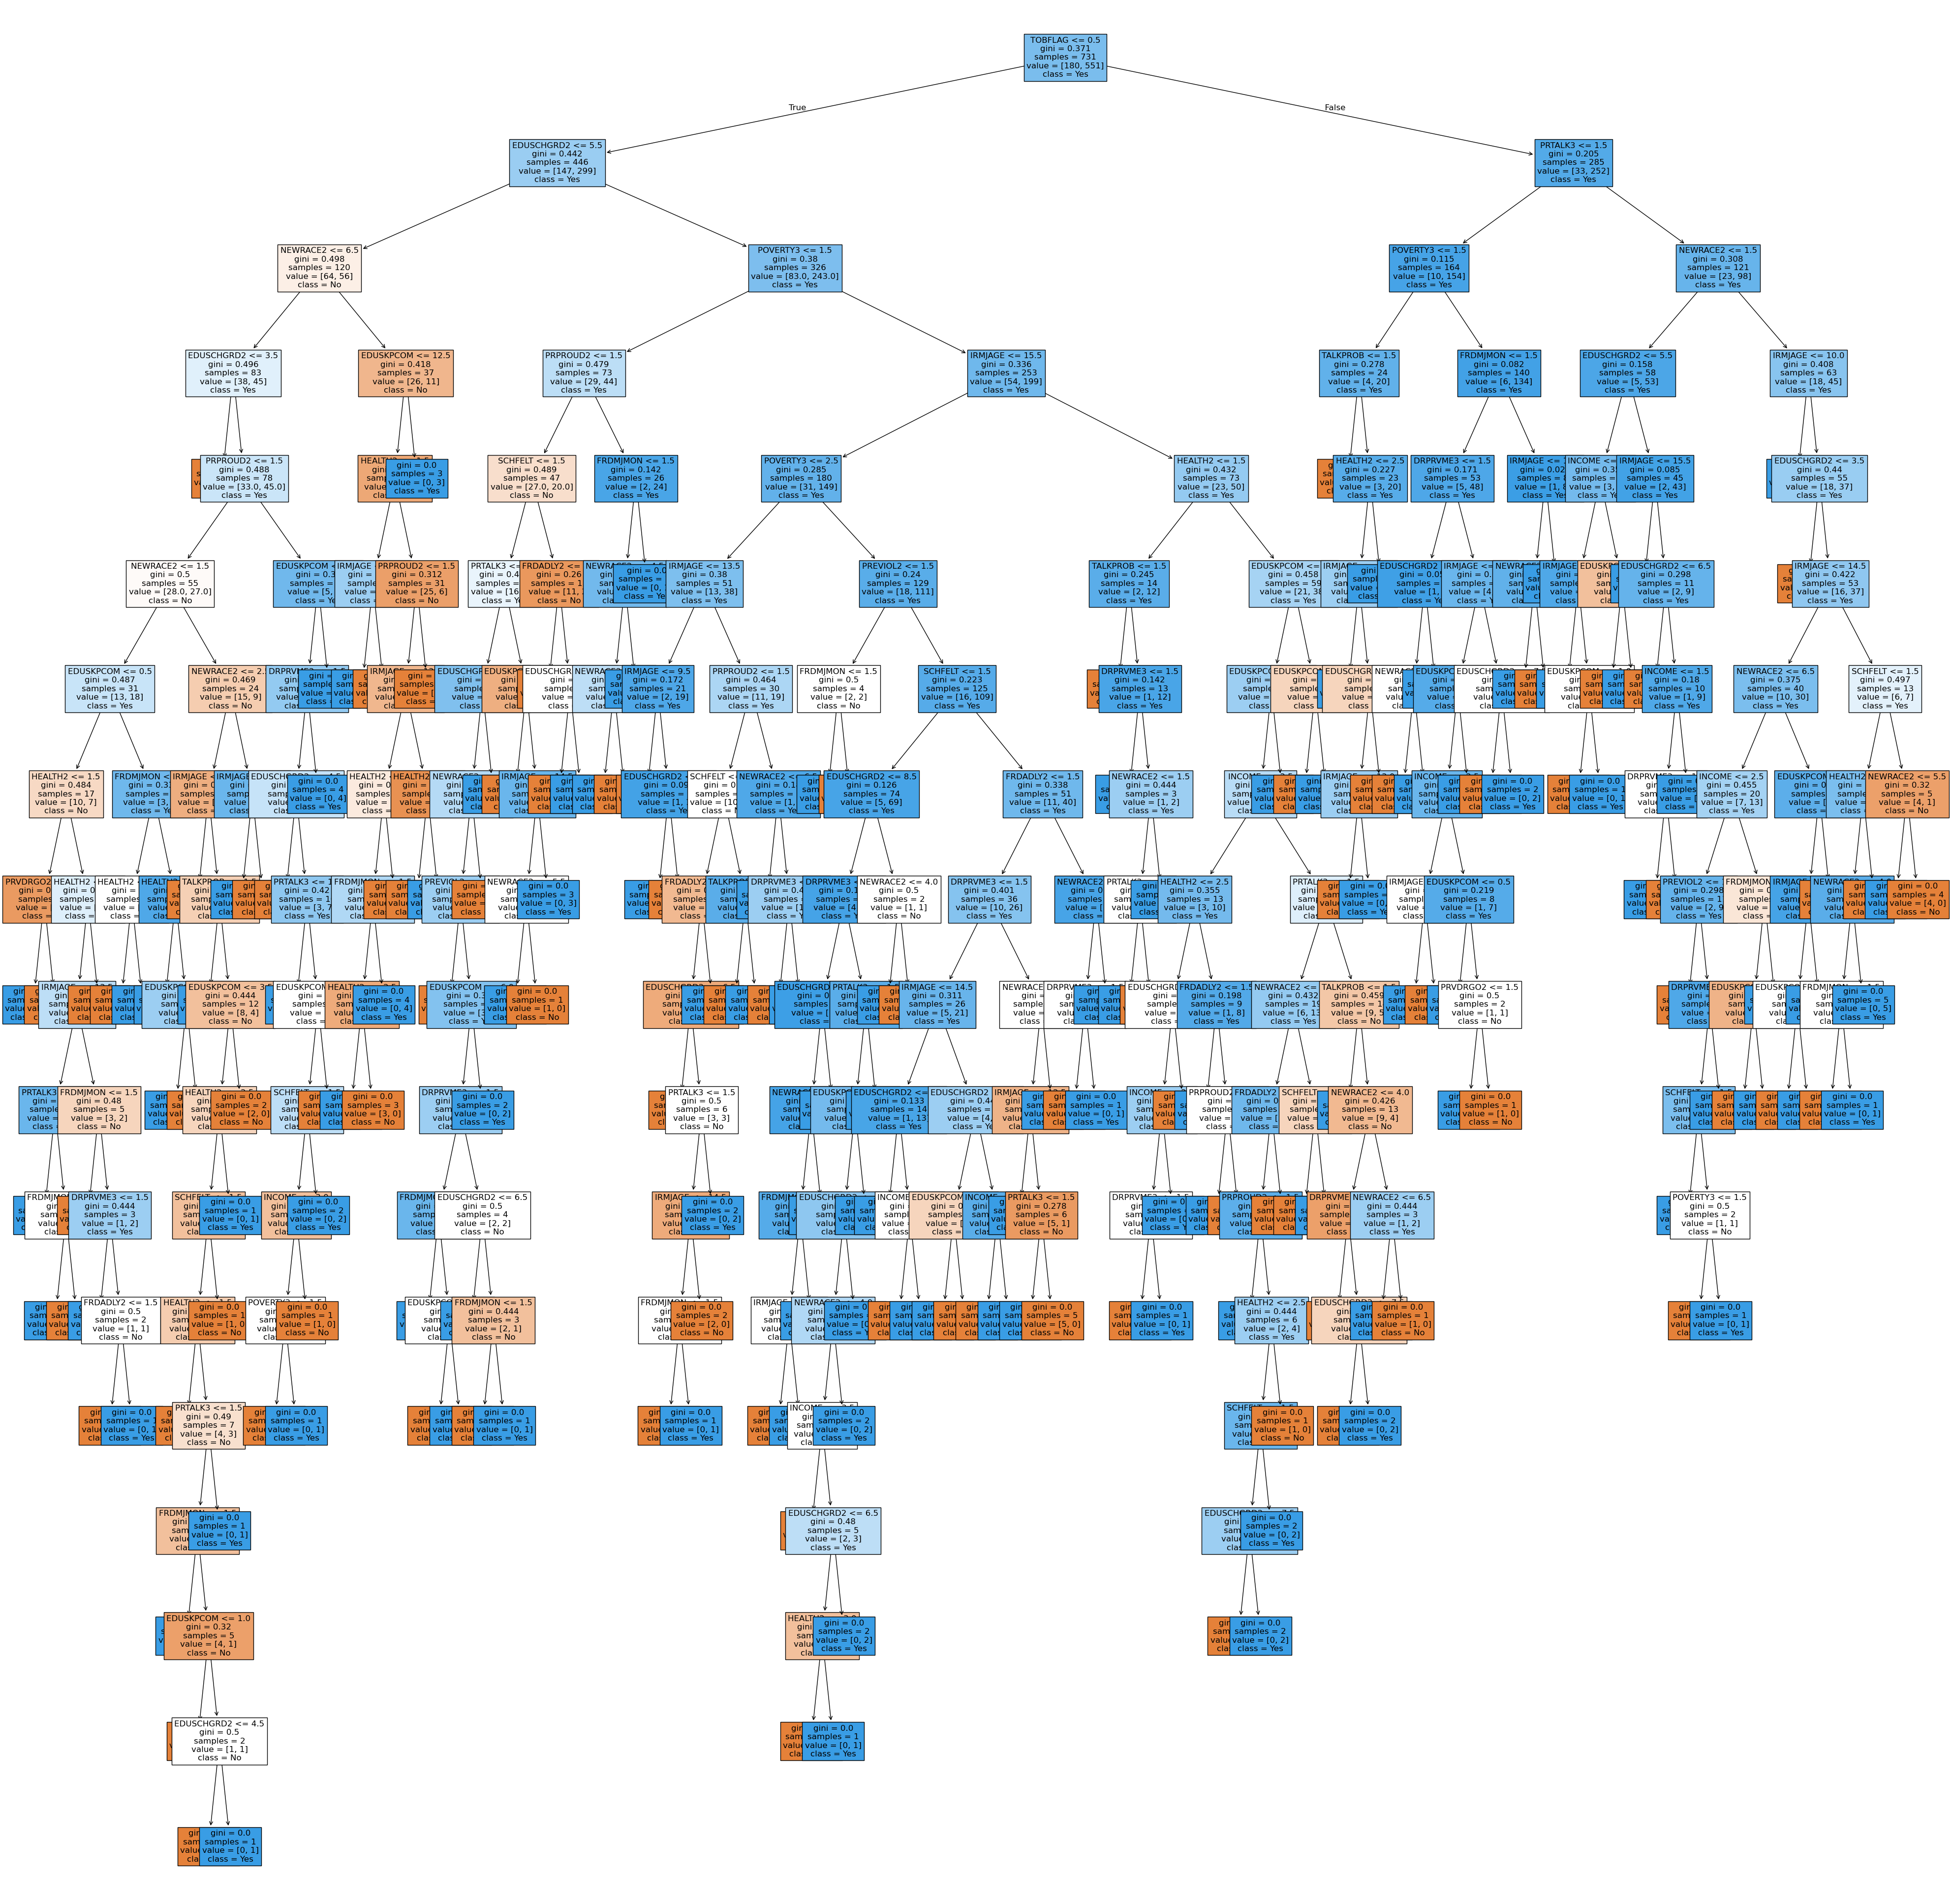

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,50))
plot_tree(model
          , filled=True
          , feature_names=X.columns
          , class_names=['No', 'Yes']
          , label='all'
          , fontsize=12)
plt.show()

In [5]:
accuracy = model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 68.79%


The Best Tree Size is : 3


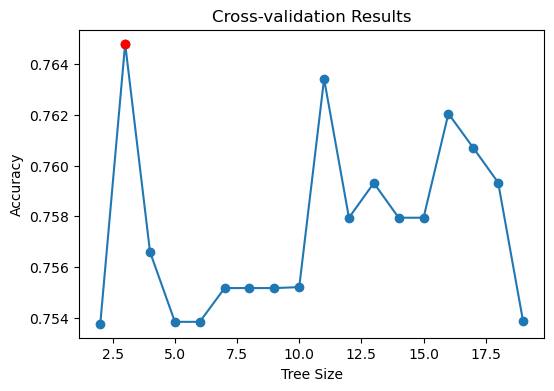

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

params = {'max_leaf_nodes': range(2, 20)}  
cv_binary = GridSearchCV(model, params, cv=10)
cv_binary.fit(X_train, y_train)
cv_results = cv_binary.cv_results_

# find the best score for max leaf nodes
best_size = cv_binary.best_params_['max_leaf_nodes']
best_score = cv_binary.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');
print("The Best Tree Size is :", best_size)


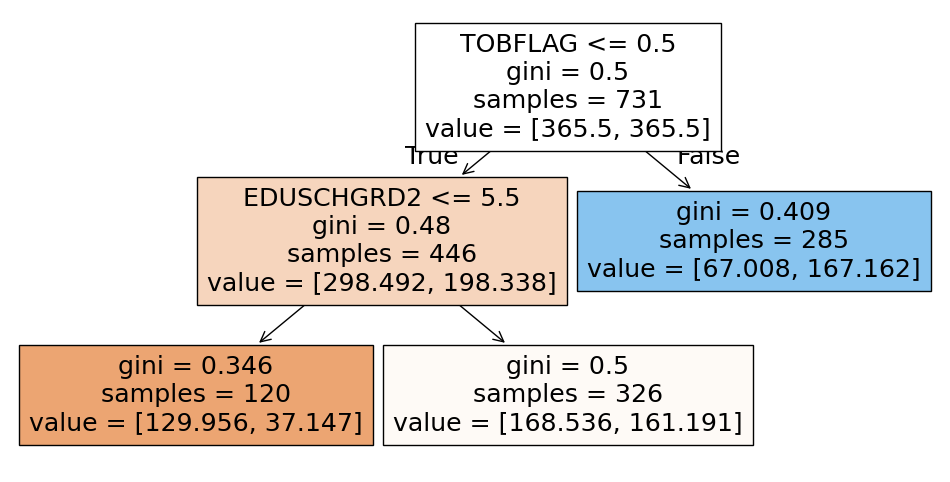

In [7]:
prune_binary = DecisionTreeClassifier(
    max_leaf_nodes=best_size,
    random_state=7,
    class_weight='balanced'
)
prune_binary.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plt.title('Pruned Tree')
plot_tree(prune_binary, feature_names=X_train.columns, filled=True);

In [8]:
trees_summary = export_text(prune_binary, feature_names=X.columns.tolist())
print(trees_summary)

|--- TOBFLAG <= 0.50
|   |--- EDUSCHGRD2 <= 5.50
|   |   |--- class: 0
|   |--- EDUSCHGRD2 >  5.50
|   |   |--- class: 0
|--- TOBFLAG >  0.50
|   |--- class: 1



In [9]:
y_pred = prune_binary.predict(X_test)

confusion_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

ALCFLAG   0    1
                
0        74  113
1        11  116


In [10]:
accuracy_prune = prune_binary.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy_prune*100))

Accuracy: 60.51%


In [13]:
bagging_model = BaggingClassifier(
    estimator =DecisionTreeClassifier(class_weight='balanced'),
    n_estimators=100,
    random_state=42
    
)
bagging_model.fit(X_train, y_train)
y_pred_bag = bagging_model.predict(X_test)
print(" Bagging Results")
print(confusion_matrix(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))

 Bagging Results
[[ 27  58]
 [ 22 207]]
              precision    recall  f1-score   support

           0       0.55      0.32      0.40        85
           1       0.78      0.90      0.84       229

    accuracy                           0.75       314
   macro avg       0.67      0.61      0.62       314
weighted avg       0.72      0.75      0.72       314



In [14]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_features='sqrt'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(" Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

 Random Forest Results
[[ 24  61]
 [ 15 214]]
              precision    recall  f1-score   support

           0       0.62      0.28      0.39        85
           1       0.78      0.93      0.85       229

    accuracy                           0.76       314
   macro avg       0.70      0.61      0.62       314
weighted avg       0.73      0.76      0.72       314



In [15]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(" Gradient Boosting Results")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

 Gradient Boosting Results
[[ 26  59]
 [ 18 211]]
              precision    recall  f1-score   support

           0       0.59      0.31      0.40        85
           1       0.78      0.92      0.85       229

    accuracy                           0.75       314
   macro avg       0.69      0.61      0.62       314
weighted avg       0.73      0.75      0.73       314



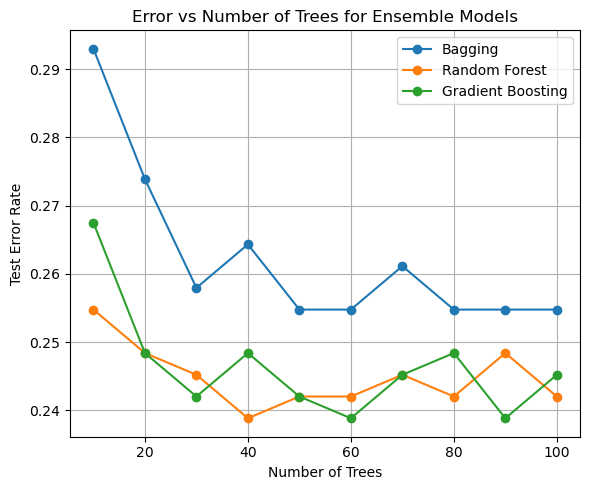

In [16]:
tree_range = range(10, 110, 10)
bag_errors, rf_errors, gb_errors = [], [], []

for n in tree_range:
    # Bagging
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced'),
        n_estimators=n, random_state=42)
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_test)
    bag_errors.append(1 - accuracy_score(y_test, y_pred))

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=n, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_errors.append(1 - accuracy_score(y_test, y_pred))

    # Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    gb_errors.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(6, 5))
plt.plot(tree_range, bag_errors, label="Bagging", marker='o')
plt.plot(tree_range, rf_errors, label="Random Forest", marker='o')
plt.plot(tree_range, gb_errors, label="Gradient Boosting", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Test Error Rate")
plt.title("Error vs Number of Trees for Ensemble Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






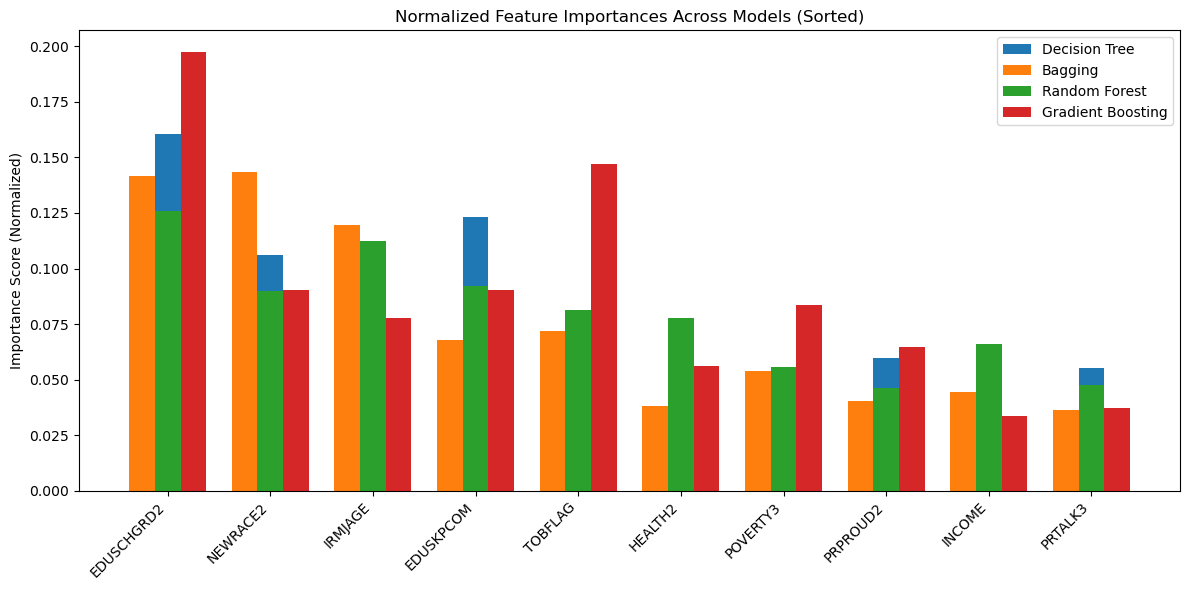

In [17]:
dt_importances = model.feature_importances_
bag_importances = bagging_model.estimators_[0].feature_importances_
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

features = X_train.columns

importance_df = pd.DataFrame({
    
    'Feature': features,
    'Decision Tree': dt_importances,
    'Bagging': bag_importances,
    'Random Forest': rf_importances,
    'Gradient Boosting': gb_importances
})

importance_df[['Decision Tree','Bagging', 'Random Forest', 'Gradient Boosting']] = importance_df[
    ['Decision Tree','Bagging', 'Random Forest', 'Gradient Boosting']
].div(importance_df[
    ['Decision Tree','Bagging', 'Random Forest', 'Gradient Boosting']
].sum(axis=0), axis=1)

importance_df['Average'] = importance_df[['Decision Tree','Bagging', 'Random Forest', 'Gradient Boosting']].mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False).head(10)

x = np.arange(len(importance_df))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, importance_df['Decision Tree'], width=width, label='Decision Tree')
plt.bar(x - width, importance_df['Bagging'], width=width, label='Bagging')
plt.bar(x, importance_df['Random Forest'], width=width, label='Random Forest')
plt.bar(x + width, importance_df['Gradient Boosting'], width=width, label='Gradient Boosting')

plt.xticks(x, importance_df['Feature'], rotation=45, ha='right')
plt.ylabel("Importance Score (Normalized)")
plt.title("Normalized Feature Importances Across Models (Sorted)")
plt.legend()
plt.tight_layout()
plt.show()


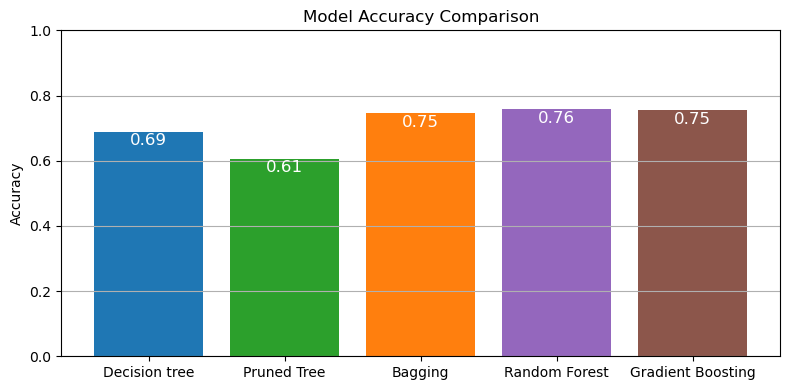

In [18]:
acc_dt = accuracy_score(y_test, model.predict(X_test))
acc_pr = accuracy_score(y_test, prune_binary.predict(X_test))
acc_bag = accuracy_score(y_test, bagging_model.predict(X_test))
acc_rf = accuracy_score(y_test, rf_model.predict(X_test))
acc_gb = accuracy_score(y_test, gb_model.predict(X_test))


accuracies = [acc_dt,acc_pr,acc_bag, acc_rf, acc_gb]
labels = ["Decision tree", "Pruned Tree", "Bagging", "Random Forest", "Gradient Boosting"]

plt.figure(figsize=(8, 4))
bars = plt.bar(labels, accuracies, color=["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd", "#8c564b"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 0.05,
             f"{height:.2f}", ha='center', va='bottom', color='white', fontsize=12)

plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

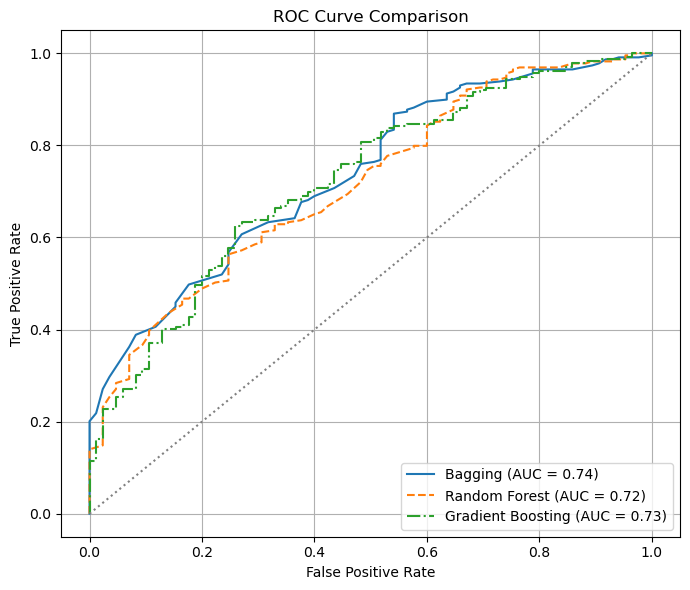

In [24]:
y_prob_bag = bagging_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

fpr_bag, tpr_bag, _ = roc_curve(y_test, y_prob_bag)
auc_bag = roc_auc_score(y_test, y_prob_bag)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
auc_gb = roc_auc_score(y_test, y_prob_gb)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr_bag, tpr_bag, label=f"Bagging (AUC = {auc_bag:.2f})", linestyle='-')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linestyle='--')
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.2f})", linestyle='-.')

plt.plot([0, 1], [0, 1], color='grey', linestyle=':')  # Reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Bagging Results (Tuned)
Best Params: {'max_samples': 0.5, 'n_estimators': 100}
[[ 29  56]
 [ 16 213]]
              precision    recall  f1-score   support

           0       0.64      0.34      0.45        85
           1       0.79      0.93      0.86       229

    accuracy                           0.77       314
   macro avg       0.72      0.64      0.65       314
weighted avg       0.75      0.77      0.74       314



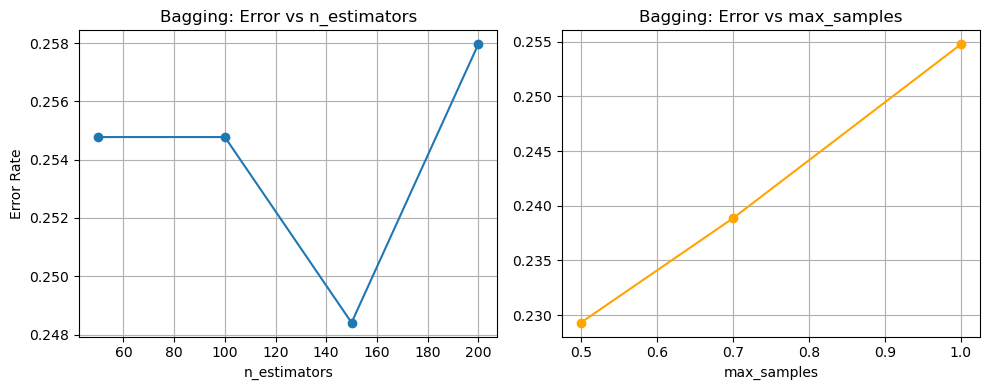

In [20]:
bag_params = {
    'n_estimators': [50, 100],
    'max_samples': [0.5, 0.8, 1.0]
}
bagging_grid = GridSearchCV(
    estimator=BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced'),
        random_state=42
    ),
    param_grid=bag_params,
    cv=5,
)
bagging_grid.fit(X_train, y_train)
bagging_model = bagging_grid.best_estimator_
y_pred_bag = bagging_model.predict(X_test)

print("Bagging Results (Tuned)")
print("Best Params:", bagging_grid.best_params_)
print(confusion_matrix(y_test, y_pred_bag))
print(classification_report(y_test, y_pred_bag))


bagging_estimators = [50, 100, 150, 200]
bagging_samples = [0.5, 0.7, 1.0]
bagging_errors_estimators, bagging_errors_samples = [], []

for n in bagging_estimators:
    model = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bagging_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

for s in bagging_samples:
    model = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), n_estimators=100, max_samples=s, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bagging_errors_samples.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(bagging_estimators, bagging_errors_estimators, marker='o')
plt.title("Bagging: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(bagging_samples, bagging_errors_samples, marker='o', color='orange')
plt.title("Bagging: Error vs max_samples")
plt.xlabel("max_samples")
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest Results (Tuned)
Best Params: {'max_depth': None, 'n_estimators': 200}
[[ 25  60]
 [ 15 214]]
              precision    recall  f1-score   support

           0       0.62      0.29      0.40        85
           1       0.78      0.93      0.85       229

    accuracy                           0.76       314
   macro avg       0.70      0.61      0.63       314
weighted avg       0.74      0.76      0.73       314



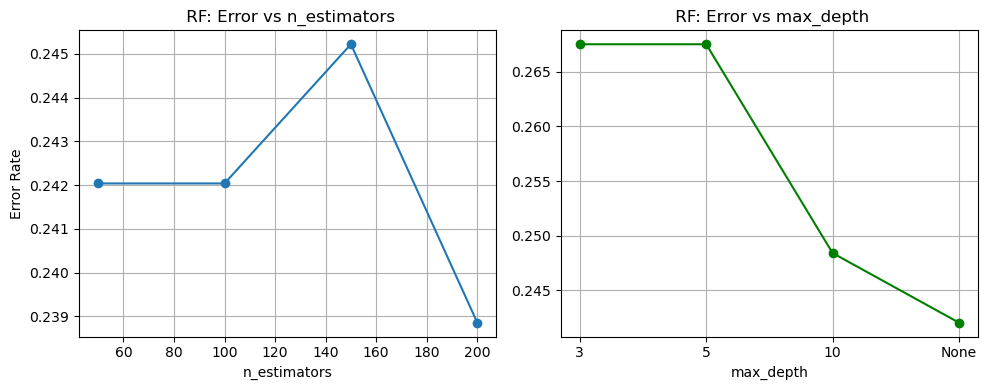

In [21]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=rf_params,
    cv=5,
)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results (Tuned)")
print("Best Params:", rf_grid.best_params_)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

rf_estimators = [50, 100, 150, 200]
rf_depths = [3, 5, 10, None]
rf_errors_estimators, rf_errors_depth = [], []

for n in rf_estimators:
    model = RandomForestClassifier(n_estimators=n, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

for d in rf_depths:
    model = RandomForestClassifier(n_estimators=100, max_depth=d, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_depth.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rf_estimators, rf_errors_estimators, marker='o')
plt.title(" RF: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([str(d) for d in rf_depths], rf_errors_depth, marker='o', color='green')
plt.title(" RF: Error vs max_depth")
plt.xlabel("max_depth")
plt.grid(True)
plt.tight_layout()
plt.show()


Gradient Boosting Results (Tuned)
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
[[ 33  52]
 [ 41 188]]
              precision    recall  f1-score   support

           0       0.45      0.39      0.42        85
           1       0.78      0.82      0.80       229

    accuracy                           0.70       314
   macro avg       0.61      0.60      0.61       314
weighted avg       0.69      0.70      0.70       314



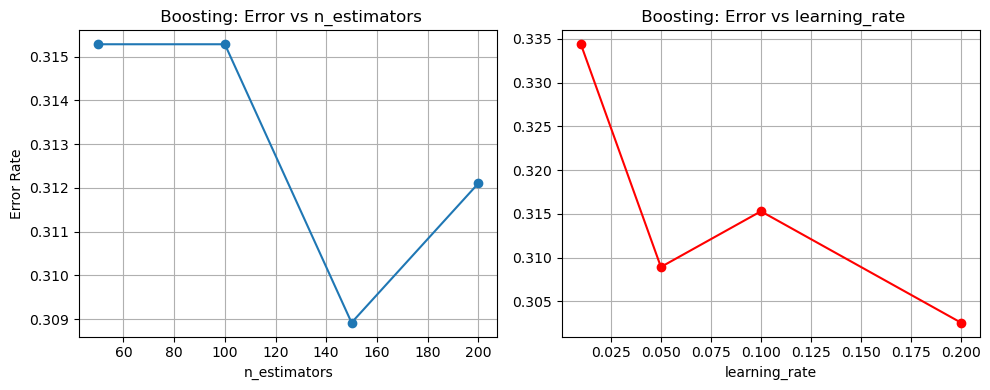

In [26]:
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05]
}
gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    cv=5,
)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
gb_grid.fit(X_train, y_train, sample_weight=sample_weights)
gb_model = gb_grid.best_estimator_
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Results (Tuned)")
print("Best Params:", gb_grid.best_params_)
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

gb_estimators = [50, 100, 150, 200]
gb_lrs = [0.01, 0.05, 0.1, 0.2]
gb_errors_estimators, gb_errors_lr = [], []

weights = compute_sample_weight(class_weight='balanced', y=y_train)

for n in gb_estimators:
    model = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)
    gb_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

for lr in gb_lrs:
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=lr, max_depth=3, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)
    gb_errors_lr.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(gb_estimators, gb_errors_estimators, marker='o')
plt.title(" Boosting: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(gb_lrs, gb_errors_lr, marker='o', color='red')
plt.title(" Boosting: Error vs learning_rate")
plt.xlabel("learning_rate")
plt.grid(True)
plt.tight_layout()
plt.show()

**Top Predictors**: Education grade level, marijuana age, peer influence, and race consistently ranked as top features.

**Best Models**:
  - **Binary Classification**: Random Forest
    
**Limitations**:
  - Class imbalance and poor recall for minority classes
    
## Potential Improvements

- Use **SMOTE** or **class reweighting** for better balance
- Consider testing additional features on mental health or social risk
    
This work can support better-targeted youth intervention strategies, highlighting the importance of early school engagement, family involvement, and peer environments.